# Purpose of this notebook:
- check the event coincidence between the CTA-LST1 and the MAGIC telescopes by using the timing information
- first, let's find the event coincidence with optimized coincidence window and time offset
- then, let's check the optimization of the coincidence window and the time offset
- finally, let's compare the event parameters of the coincident events

Author: Yoshiki Ohtani (ICRR, ohtani@icrr.u-tokyo.ac.jp) 

In [1]:
import re
import sys
import time
import glob
import uproot
import warnings
import numpy as np 
import pandas as pd
from decimal import Decimal
from astropy.time import Time
from matplotlib import pyplot, colors
from scipy.optimize import curve_fit

In [2]:
pyplot.rcParams['figure.figsize'] = (8, 6)
pyplot.rcParams['font.size'] = 15
pyplot.rcParams['grid.linestyle'] = ':'

In [3]:
warnings.simplefilter('ignore')
colors_default = pyplot.rcParams['axes.prop_cycle'].by_key()['color']

# Load the MAGIC data

Get the path to the  data:

In [4]:
data_mask = '/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/MAGIC/CrabNebula/20200118/SuperStar/*_05088502*.root'
data_path_magic = glob.glob(data_mask)[0]

In [5]:
data_path_magic

'/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/MAGIC/CrabNebula/20200118/SuperStar/20200118_05088502_S_CrabNebula-W0.40+215.root'

Load the data and make a HDF5 data frame:

In [6]:
# === function to convert the unit of MAGIC Length and Width from [mm] to [deg]
def mm2deg_magic(data):
    foclen = 16.969999 # [m]
    mm2m = 1e-3
    
    return np.rad2deg(np.arctan2(data*mm2m, foclen))

In [7]:
data_magic = pd.DataFrame()
cm2m = 1e-2
gev2tev = 1e-3
ms2sec = 1e-3
ns2sec = 1e-9

with uproot.open(data_path_magic) as input_data:

    for tel_id in [1, 2]:
        
        print(f'Loading the MAGIC{tel_id} event information...')
        
        df = pd.DataFrame()

        # === event info ===
        df['event_id_magic'] = np.array(list(map(int, input_data['Events'][f'MRawEvtHeader_{tel_id}.fStereoEvtNumber'].array())))
        df['run_id_magic'] = np.repeat(input_data['RunHeaders'][f'MRawRunHeader_{tel_id}.fRunNumber'].array()[0], len(df))
        df['tel_id'] = np.repeat(tel_id, len(df))

        # === pointing parameters ===
        df['alt_tel'] = np.deg2rad(90 - input_data['Events'][f'MPointingPos_{tel_id}.fZd'].array())    # unit: [rad]
        df['az_tel'] = np.deg2rad(input_data['Events'][f'MPointingPos_{tel_id}.fAz'].array())     # unit: [rad]

        # === timing parameters ===
        df['mjd'] = input_data['Events'][f'MTime_{tel_id}.fMjd'].array()   # unit: [mjd]
        df['millisec'] = input_data['Events'][f'MTime_{tel_id}.fTime.fMilliSec'].array()    # unit: [millisec]
        df['nanosec'] = input_data['Events'][f'MTime_{tel_id}.fNanoSec'].array()    # unit: [nanosec]
        
        # === Hillas parameters ===
        df['intensity'] = input_data['Events'][f'MHillas_{tel_id}.fSize'].array()  # unit: [phe]
        df['length'] = mm2deg_magic(input_data['Events'][f'MHillas_{tel_id}.fLength'].array())    # unit: [deg]
        df['width'] = mm2deg_magic(input_data['Events'][f'MHillas_{tel_id}.fWidth'].array())    # unit: [deg]

        # === MAGIC RF-estimated parameters === 
#         df['reco_az_magic'] = np.deg2rad(input_data['Events'][f'MStereoParDisp.fDirectionAz'].array())  # unit: [rad]
#         df['reco_alt_magic'] = np.deg2rad(90 - input_data['Events'][f'MStereoParDisp.fDirectionZd'].array())  # unit: [rad]
#         df['reco_energy_magic'] = input_data['Events']['MEnergyEst.fEnergy'].array()*gev2tev   # unit: [TeV]
#         df['reco_impact_magic'] = input_data['Events'][f'MStereoParDisp.fM{tel_id}Impact'].array()*cm2m  # unit: [m]
#         df['reco_core_x_magic'] = input_data['Events'][f'MStereoParDisp.fCoreX'].array()*cm2m  # unit: [m]
#         df['reco_core_y_magic'] = input_data['Events'][f'MStereoParDisp.fCoreY'].array()*cm2m  # unit: [m]
#         df['theta2_magic'] = input_data['Events']['MStereoParDisp.fTheta2'].array()  # unit: [deg^2] 
#         df['hadronness_magic'] = input_data['Events']['MHadronness.fHadronness'].array()

        data_magic = data_magic.append(df)
        
print('Done.')

Loading the MAGIC1 event information...
Loading the MAGIC2 event information...
Done.


Set the index to the data set:

In [8]:
data_magic.set_index(['run_id_magic', 'event_id_magic', 'tel_id'], inplace=True)
data_magic.sort_index(inplace=True)

Check the contents of the data frame:

In [9]:
data_magic.head(4)

alt_tel    az_tel    mjd  millisec  \
run_id_magic event_id_magic tel_id                                        
5088502      2507           1       1.446440  2.921982  58866  -4085608   
                            2       1.446438  2.921965  58866  -4085608   
             2508           1       1.446440  2.921982  58866  -4085608   
                            2       1.446438  2.921965  58866  -4085608   

                                    nanosec   intensity    length     width  
run_id_magic event_id_magic tel_id                                           
5088502      2507           1         54800  264.468750  0.560503  0.088699  
                            2         54800   97.468750  0.420976  0.058726  
             2508           1        129400   66.312500  0.087841  0.053840  
                            2        129400  128.414062  0.129082  0.057076

In [10]:
data_magic.tail(4)

alt_tel    az_tel    mjd  millisec  \
run_id_magic event_id_magic tel_id                                        
5088502      292663         1       1.438685  3.557192  58866  -2900319   
                            2       1.438685  3.557190  58866  -2900319   
             292664         1       1.438685  3.557193  58866  -2900317   
                            2       1.438685  3.557191  58866  -2900317   

                                    nanosec    intensity    length     width  
run_id_magic event_id_magic tel_id                                            
5088502      292663         1        325400  1777.835938  0.386640  0.261632  
                            2        325400   474.609375  0.548003  0.074806  
             292664         1        993400    89.640625  0.094644  0.059162  
                            2        993400   748.195312  0.382640  0.188924

In [11]:
data_magic.columns

Index(['alt_tel', 'az_tel', 'mjd', 'millisec', 'nanosec', 'intensity',
       'length', 'width'],
      dtype='object')

In [12]:
for tel_id in [1, 2]:
    df = data_magic.query(f'tel_id == {tel_id}')
    print(f'MAGIC{tel_id}:  {len(df)} events')

MAGIC1:  213524 events
MAGIC2:  213524 events


# Load the LST1 data 

Define the path to the LST1 data file:

In [13]:
data_path_lst = '/fefs/aswg/data/real/DL1/20200117/v0.6.1_v05/dl1_LST-1.Run01818.0000.h5'

Load the LST1 data file:

In [14]:
df_lst = pd.read_hdf(data_path_lst, key='dl1/event/telescope/parameters/LST_LSTCam')
n_events_lst = len(df_lst)
print(f'LST1: {n_events_lst} events')

LST1: 53000 events


Set the index to the data set:

In [15]:
parse = re.findall('.*Run(\d+).(\d+).h5', data_path_lst)[0]
run_id_lst = int(parse[0])
subrun_id_lst = int(parse[1])
print(f'run_id_lst = {run_id_lst}, subrun_id_lst = {subrun_id_lst}')

run_id_lst = 1818, subrun_id_lst = 0


In [16]:
df_lst['run_id_lst'] = np.repeat(run_id_lst, n_events_lst)
df_lst['subrun_id_lst'] = np.repeat(subrun_id_lst, n_events_lst)
df_lst.rename(columns={'event_id': 'event_id_lst'}, inplace=True)
df_lst.set_index(['run_id_lst', 'subrun_id_lst', 'event_id_lst', 'tel_id'], inplace=True)

Check the contents of the data frame:

In [17]:
df_lst.head()

intensity  log_intensity  \
run_id_lst subrun_id_lst event_id_lst tel_id                                 
1818       0             1            1        14762.974084       4.169174   
                         2            1          203.007236       2.307512   
                         3            1          851.067563       2.929964   
                         4            1          144.740426       2.160590   
                         5            1       140701.506618       5.148299   

                                                     x         y         r  \
run_id_lst subrun_id_lst event_id_lst tel_id                                 
1818       0             1            1       0.000539  0.007186  0.007206   
                         2            1       0.331037 -0.259864  0.420850   
                         3            1       0.172461 -0.593237  0.617797   
                         4            1      -0.590588 -0.754351  0.958039   
                         5            1       0.005977 -0.002004  0.006304   

                                                   phi    length     width  \
run_id_lst subrun_id_lst event_id_lst tel_id                                 
1818       0             1            1       1.495900  1.161459  1.149189   
                         2            1      -0.665527  0.212872  0.099814   
                         3            1      -1.287882  0.335565  0.292588   
                         4            1      -2.235029  0.092224  0.082554   
                         5            1      -0.323467  1.160524  1.153254   

                                                   psi  skewness  ...  \
run_id_lst subrun_id_lst event_id_lst tel_id                      ...   
1818       0             1            1       0.799104  0.002861  ...   
                         2            1      -0.584904  0.300742  ...   
                         3            1      -0.180452  0.522105  ...   
                         4            1      -0.403947 -0.010595  ...   
                         5            1       1.302015  0.000159  ...   

                                                  tib_time  mc_type  \
run_id_lst subrun_id_lst event_id_lst tel_id                          
1818       0             1            1       1.579302e+09       -1   
                         2            1       1.579302e+09       -1   
                         3            1       1.579302e+09       -1   
                         4            1       1.579302e+09       -1   
                         5            1       1.579302e+09       -1   

                                              mc_core_distance        wl  \
run_id_lst subrun_id_lst event_id_lst tel_id                               
1818       0             1            1                    NaN  0.989435   
                         2            1                    NaN  0.468893   
                         3            1                    NaN  0.871927   
                         4            1                    NaN  0.895142   
                         5            1                    NaN  0.993735   

                                              tel_pos_x  tel_pos_y  tel_pos_z  \
run_id_lst subrun_id_lst event_id_lst tel_id                                    
1818       0             1            1            50.0       50.0       16.0   
                         2            1            50.0       50.0       16.0   
                         3            1            50.0       50.0       16.0   
                         4            1            50.0       50.0       16.0   
                         5            1            50.0       50.0       16.0   

                                              trigger_type  ucts_trigger_type  \
run_id_lst subrun_id_lst event_id_lst tel_id                                    
1818       0             1            1                  1                  1   
                         2            1                

In [18]:
df_lst.tail()

intensity  log_intensity  \
run_id_lst subrun_id_lst event_id_lst tel_id                              
1818       0             52996        1       583.948787       2.766375   
                         52997        1       274.999539       2.439332   
                         52998        1       228.385739       2.358669   
                         52999        1        34.019266       1.531725   
                         53000        1        35.019754       1.544313   

                                                     x         y         r  \
run_id_lst subrun_id_lst event_id_lst tel_id                                 
1818       0             52996        1       0.713375 -0.665973  0.975922   
                         52997        1      -0.202206  0.302803  0.364111   
                         52998        1      -0.865792  0.371986  0.942321   
                         52999        1      -0.063782 -0.698295  0.701202   
                         53000        1      -0.585310  0.532838  0.791520   

                                                   phi    length     width  \
run_id_lst subrun_id_lst event_id_lst tel_id                                 
1818       0             52996        1      -0.751046  0.181385  0.116436   
                         52997        1       2.159569  0.231470  0.107302   
                         52998        1       2.735791  0.146073  0.117497   
                         52999        1      -1.661884  0.087874  0.048725   
                         53000        1       2.403088  0.084528  0.055556   

                                                   psi  skewness  ...  \
run_id_lst subrun_id_lst event_id_lst tel_id                      ...   
1818       0             52996        1      -0.319293 -0.845498  ...   
                         52997        1       0.732474 -0.394676  ...   
                         52998        1      -0.832632  0.453027  ...   
                         52999        1       1.228290  0.126621  ...   
                         53000        1       0.209505  0.610456  ...   

                                                  tib_time  mc_type  \
run_id_lst subrun_id_lst event_id_lst tel_id                          
1818       0             52996        1       1.579302e+09       -1   
                         52997        1       1.579302e+09       -1   
                         52998        1       1.579302e+09       -1   
                         52999        1       1.579302e+09       -1   
                         53000        1       1.579302e+09       -1   

                                              mc_core_distance        wl  \
run_id_lst subrun_id_lst event_id_lst tel_id                               
1818       0             52996        1                    NaN  0.641924   
                         52997        1                    NaN  0.463570   
                         52998        1                    NaN  0.804368   
                         52999        1                    NaN  0.554485   
                         53000        1                    NaN  0.657246   

                                              tel_pos_x  tel_pos_y  tel_pos_z  \
run_id_lst subrun_id_lst event_id_lst tel_id                                    
1818       0             52996        1            50.0       50.0       16.0   
                         52997        1            50.0       50.0       16.0   
                         52998        1            50.0       50.0       16.0   
                         52999        1            50.0       50.0       16.0   
                         53000        1            50.0       50.0       16.0   

                                              trigger_type  ucts_trigger_type  \
run_id_lst subrun_id_lst event_id_lst tel_id                                    
1818       0             52996        1                  1                  1   
                         52997        1                  1               

In [19]:
df_lst.columns

Index(['intensity', 'log_intensity', 'x', 'y', 'r', 'phi', 'length', 'width',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'alt_tel', 'az_tel', 'obs_id', 'calibration_id',
       'dragon_time', 'ucts_time', 'tib_time', 'mc_type', 'mc_core_distance',
       'wl', 'tel_pos_x', 'tel_pos_y', 'tel_pos_z', 'trigger_type',
       'ucts_trigger_type', 'trigger_time'],
      dtype='object')

# Check the event coincidence

Define the parameters used for the coincidence:

In [20]:
window = 6e-7  # optimized coincidence window, unit: [sec]
offset_bins = np.round(np.arange(-5e-6, 0, 1e-7), 7)

In [21]:
offset_bins

array([-5.0e-06, -4.9e-06, -4.8e-06, -4.7e-06, -4.6e-06, -4.5e-06,
       -4.4e-06, -4.3e-06, -4.2e-06, -4.1e-06, -4.0e-06, -3.9e-06,
       -3.8e-06, -3.7e-06, -3.6e-06, -3.5e-06, -3.4e-06, -3.3e-06,
       -3.2e-06, -3.1e-06, -3.0e-06, -2.9e-06, -2.8e-06, -2.7e-06,
       -2.6e-06, -2.5e-06, -2.4e-06, -2.3e-06, -2.2e-06, -2.1e-06,
       -2.0e-06, -1.9e-06, -1.8e-06, -1.7e-06, -1.6e-06, -1.5e-06,
       -1.4e-06, -1.3e-06, -1.2e-06, -1.1e-06, -1.0e-06, -9.0e-07,
       -8.0e-07, -7.0e-07, -6.0e-07, -5.0e-07, -4.0e-07, -3.0e-07,
       -2.0e-07, -1.0e-07, -0.0e+00])

Check the event coincidence:

2648 MAGIC events are found within the LST1 observation window.

Checking the coincidence...
time_offset = -5.0 [us]  -->  4 events
time_offset = -4.9 [us]  -->  3 events
time_offset = -4.8 [us]  -->  2 events
time_offset = -4.7 [us]  -->  1 events
time_offset = -4.6 [us]  -->  1 events
time_offset = -4.5 [us]  -->  0 events
time_offset = -4.4 [us]  -->  1 events
time_offset = -4.3 [us]  -->  1 events
time_offset = -4.2 [us]  -->  1 events
time_offset = -4.1 [us]  -->  1 events
time_offset = -4.0 [us]  -->  1 events
time_offset = -3.9 [us]  -->  2 events
time_offset = -3.8 [us]  -->  2 events
time_offset = -3.7 [us]  -->  2 events
time_offset = -3.6 [us]  -->  2 events
time_offset = -3.5 [us]  -->  174 events
time_offset = -3.4 [us]  -->  524 events
time_offset = -3.3 [us]  -->  1277 events
time_offset = -3.2 [us]  -->  1528 events
time_offset = -3.1 [us]  -->  1671 events
time_offset = -3.0 [us]  -->  1679 events
time_offset = -2.9 [us]  -->  1525 events
time_offset = -2.8 [us]  -->  

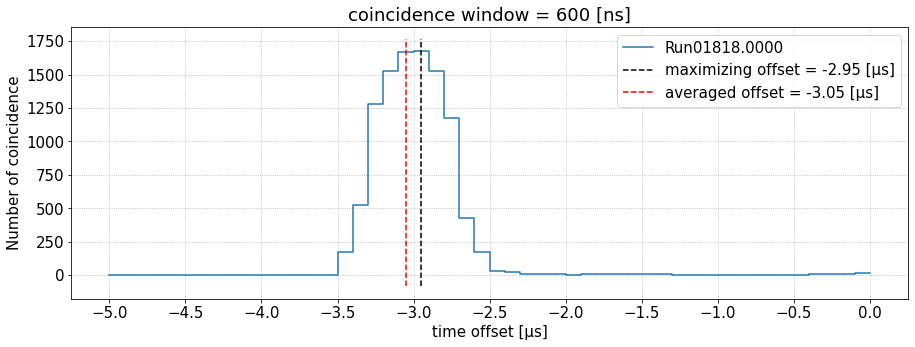

In [22]:
start_time = time.time()
sec2us = 1e6
sec2ns = 1e9

# === extract the MAGIC events within the LST1 data observation time window === 
obs_day = Time(data_magic['mjd'].values[0], format='mjd', scale='utc')
time_lst_tmp = np.array(list(map(Decimal, list(map(str, df_lst['dragon_time'].values)))))  # dragon_time is the most stable timestamp so far 
time_lst = np.array(list(map(float, time_lst_tmp - Decimal(str(obs_day.unix)))))

df_magic = {1: data_magic.query('tel_id == 1'),
                       2: data_magic.query('tel_id == 2')}

time_magic_tmp = np.round(df_magic[1]['millisec'].values*ms2sec + df_magic[1]['nanosec'].values*ns2sec, 7)

condition = (time_magic_tmp > time_lst[0] + offset_bins[0] - window) & (time_magic_tmp < time_lst[-1] + offset_bins[-1] + window)

if np.sum(condition) == 0:
    print('No MAGIC events within the LST data observation time window. Check your MAGIC and LST input files. Exiting.')
    sys.exit()
else:
    print(f'{np.sum(condition)} MAGIC events are found within the LST1 observation window.\n')
    n_events_magic = np.sum(condition)
    df_magic[1] = df_magic[1].iloc[condition]
    df_magic[2] = df_magic[2].iloc[condition]

time_magic = time_magic_tmp[condition]

# === check the event coincidence in each time offset ===
print('Checking the coincidence...')

nums_stereo = np.zeros(len(offset_bins), dtype=np.int)

for i_off, offset in enumerate(offset_bins): 
    
    time_lim_lo = np.round(time_lst + offset - window/2, 7)
    time_lim_hi = np.round(time_lst + offset + window/2, 7)
    
    for i_ev in range(n_events_lst):
        
        condition_lo = ( time_lim_lo[i_ev] <  time_magic )
        condition_hi = ( time_magic <= time_lim_hi[i_ev] )

        if np.count_nonzero(condition_lo&condition_hi) == 1:
            nums_stereo[i_off] += int(1)
            
    print(f'time_offset = {offset*sec2us:.01f} [us]  -->  {nums_stereo[i_off]} events')

# === average the time-offset === 
index_max = np.where(nums_stereo == np.max(nums_stereo))[0]
index_max = np.append(index_max, index_max[-1]+1)
offset_max = np.average(offset_bins[index_max])

indices = np.where((offset_bins >= offset_max - window) & (offset_bins <= offset_max + window))
offset_avg = np.average(offset_bins[indices], weights=nums_stereo[indices])
num_avg = nums_stereo[offset_bins < offset_avg][-1]

print(f'\nAveraged time-offset = {offset_avg*sec2us:.2f} [µs]')
print(f'--> Number of coincidence = {num_avg}')
print(f'--> Fraction of the coincidence = {num_avg}/{n_events_magic} = {num_avg/n_events_magic*100:.1f}%\n')

# === plot the coincidence distribution ===
pyplot.figure(figsize=(15, 5))
pyplot.title(f'coincidence window = {window*sec2ns:.0f} [ns]')
pyplot.xlabel('time offset [µs]')
pyplot.ylabel('Number of coincidence')

pyplot.step(offset_bins*sec2us, nums_stereo, label=f'Run{str(run_id_lst).zfill(5)}.{str(subrun_id_lst).zfill(4)}', where='post')
ylim = pyplot.ylim()

pyplot.plot((offset_max*sec2us, offset_max*sec2us), ylim, linestyle='--', color='black', 
                        label=f'maximizing offset = {offset_max*sec2us:.2f} [µs]')
pyplot.plot((offset_avg*sec2us, offset_avg*sec2us), ylim, linestyle='--', color='red', 
                        label=f'averaged offset = {offset_avg*sec2us:.2f} [µs]')

pyplot.xticks(np.arange(-5, 0.5, 0.5))

pyplot.legend()
pyplot.grid()

end_time = time.time()
print(f'elapsed time = {end_time - start_time:.1f} [sec]')

# Optimize the window and the time-offset

Define the bins of the coincidence window:

In [23]:
window_bins = np.round(np.arange(2.0e-7, 1.5e-6, 2e-7), 7)

In [24]:
window_bins

array([2.0e-07, 4.0e-07, 6.0e-07, 8.0e-07, 1.0e-06, 1.2e-06, 1.4e-06])

Checking the coincidence...
window = 200 [ns]  -->  offset_max = -3.05 [us],  offset_avg = -3.06 [us],  number of coincidence = 1104 events
window = 400 [ns]  -->  offset_max = -3.05 [us],  offset_avg = -3.06 [us],  number of coincidence = 1528 events
window = 600 [ns]  -->  offset_max = -2.95 [us],  offset_avg = -3.05 [us],  number of coincidence = 1671 events
window = 800 [ns]  -->  offset_max = -2.90 [us],  offset_avg = -3.05 [us],  number of coincidence = 1679 events
window = 1000 [ns]  -->  offset_max = -2.75 [us],  offset_avg = -3.05 [us],  number of coincidence = 1698 events
window = 1200 [ns]  -->  offset_max = -2.70 [us],  offset_avg = -3.05 [us],  number of coincidence = 1699 events
window = 1400 [ns]  -->  offset_max = -2.67 [us],  offset_avg = -3.05 [us],  number of coincidence = 1703 events

elapsed time = 133.1 [sec]


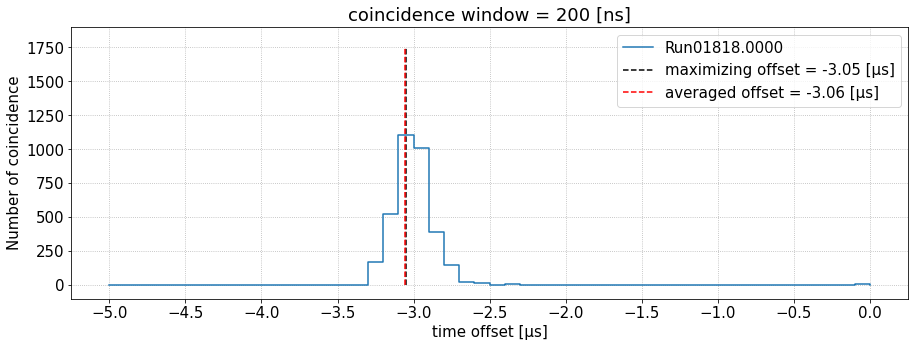

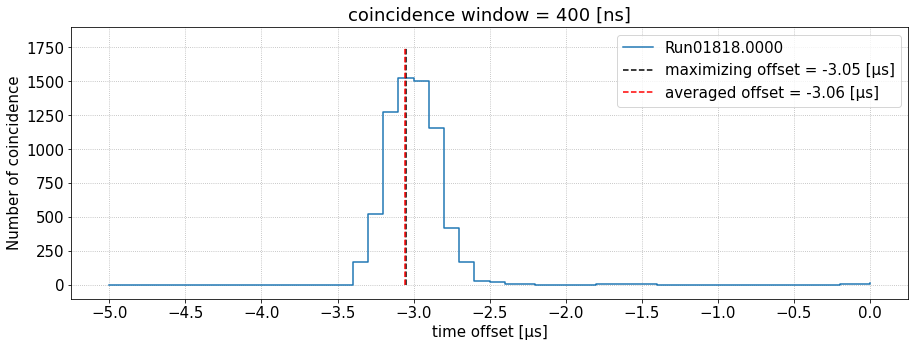

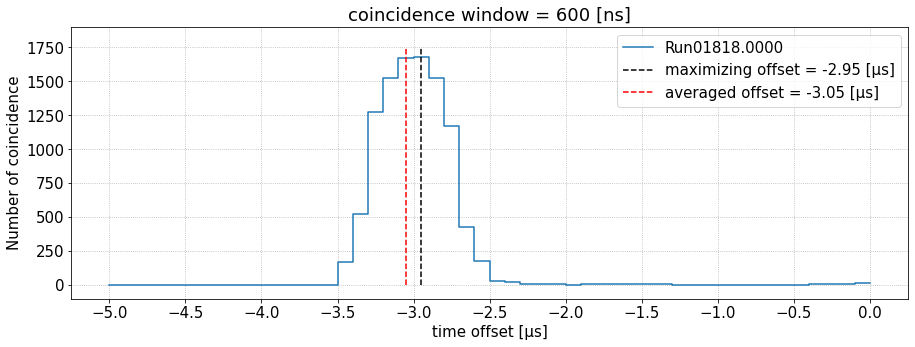

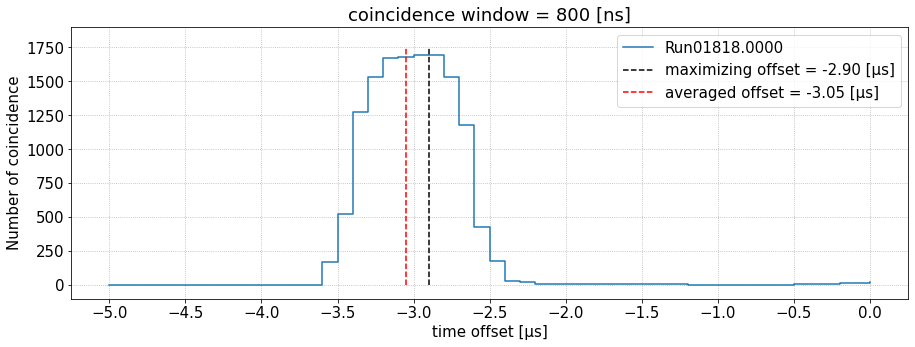

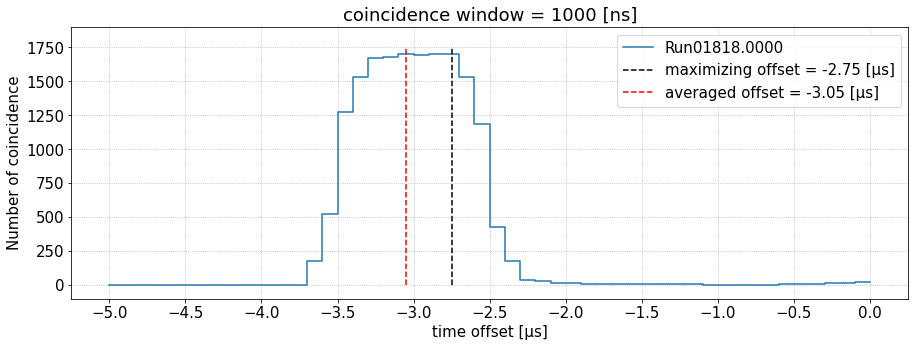

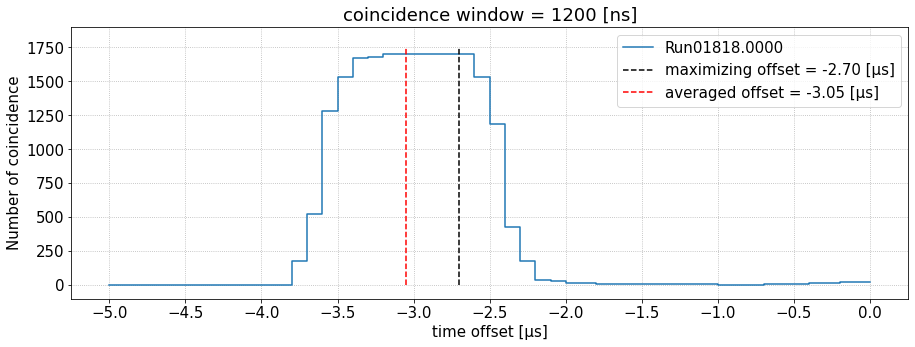

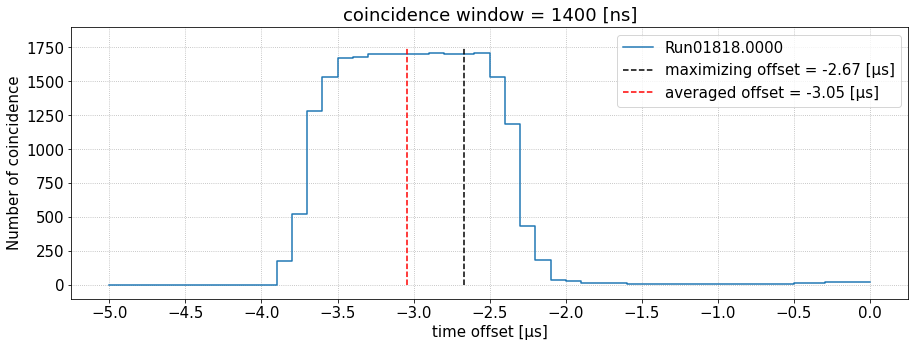

In [25]:
start_time = time.time()

# === check the event coincidence in each coincidence window ===
print('Checking the coincidence...')

nums_stereo_avg = []
offsets_max = []
offsets_avg = []

for i_win, window in enumerate(window_bins):

    nums_stereo = np.zeros(len(offset_bins), dtype=np.int)

    for i_off, offset in enumerate(offset_bins): 

        time_lim_lo = np.round(time_lst + offset - window/2, 7)
        time_lim_hi = np.round(time_lst + offset + window/2, 7)

        for i_ev in range(n_events_lst):

            condition_lo = ( time_lim_lo[i_ev] <  time_magic )
            condition_hi = ( time_magic <= time_lim_hi[i_ev] )

            if np.count_nonzero(condition_lo&condition_hi) == 1:
                nums_stereo[i_off] += int(1)

    # === average the time-offset === 
    index_max = np.where(nums_stereo == np.max(nums_stereo))[0]
    index_max = np.append(index_max, index_max[-1]+1)
    offset_max = np.average(offset_bins[index_max])

    indices = np.where((offset_bins >= offset_max - window) & (offset_bins <= offset_max + window))
    offset_avg = np.average(offset_bins[indices], weights=nums_stereo[indices])

    print(f'window = {window*sec2ns:.0f} [ns]  -->  offset_max = {offset_max*sec2us:.2f} [us],  offset_avg = {offset_avg*sec2us:.2f} [us],  '\
             + f'number of coincidence = {nums_stereo[offset_bins < offset_avg][-1]} events')
    
    nums_stereo_avg.append(nums_stereo[offset_bins < offset_avg][-1])
    offsets_max.append(offset_max)
    offsets_avg.append(offset_avg)
    
    # === plot the coincidence distribution ===
    pyplot.figure(figsize=(15, 5))
    ylim = pyplot.ylim(-100, 1900)
    pyplot.title(f'coincidence window = {window*sec2ns:.0f} [ns]')
    pyplot.xlabel('time offset [µs]')
    pyplot.ylabel('Number of coincidence')

    pyplot.step(offset_bins*sec2us, nums_stereo, label=f'Run{str(run_id_lst).zfill(5)}.{str(subrun_id_lst).zfill(4)}', where='post')

    pyplot.plot((offset_max*sec2us, offset_max*sec2us), (0, 1750), linestyle='--', color='black', 
                            label=f'maximizing offset = {offset_max*sec2us:.2f} [µs]')
    pyplot.plot((offset_avg*sec2us, offset_avg*sec2us), (0, 1750), linestyle='--', color='red', 
                            label=f'averaged offset = {offset_avg*sec2us:.2f} [µs]')

    pyplot.xticks(np.arange(-5, 0.5, 0.5))

    pyplot.legend()
    pyplot.grid()
    
end_time = time.time()
print(f'\nelapsed time = {end_time - start_time:.1f} [sec]')

Check the relation of the window with the time offsets and the number of coincidence: 

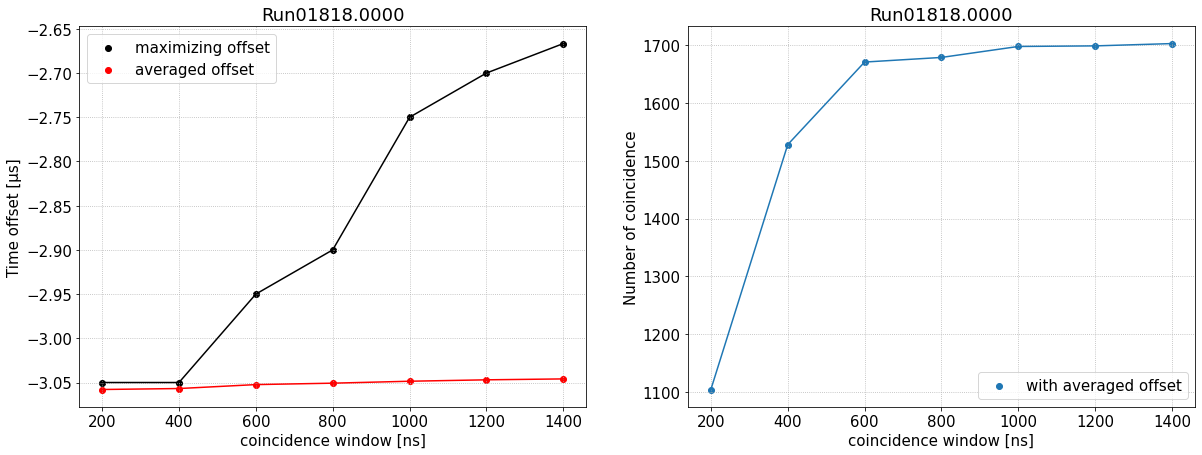

In [26]:
pyplot.figure(figsize=(20, 7))
grid = (1, 2)

# === number of coincidene w.r.t. the coincidence window === 
pyplot.subplot2grid(grid, (0, 0))
pyplot.title(f'Run{str(run_id_lst).zfill(5)}.{str(subrun_id_lst).zfill(4)}')
pyplot.xlabel('coincidence window [ns]')
pyplot.ylabel('Time offset [µs]')

pyplot.plot(window_bins*sec2ns, np.array(offsets_max)*sec2us, color='black')
pyplot.scatter(window_bins*sec2ns, np.array(offsets_max)*sec2us, label=f'maximizing offset', color='black')

pyplot.plot(window_bins*sec2ns, np.array(offsets_avg)*sec2us, color='red')
pyplot.scatter(window_bins*sec2ns, np.array(offsets_avg)*sec2us, label=f'averaged offset', color='red')

pyplot.legend()
pyplot.grid()

# === time offsets w.r.t. the coincidence window === 
pyplot.subplot2grid(grid, (0, 1))
pyplot.title(f'Run{str(run_id_lst).zfill(5)}.{str(subrun_id_lst).zfill(4)}')
pyplot.xlabel('coincidence window [ns]')
pyplot.ylabel('Number of coincidence')

pyplot.plot(window_bins*sec2ns, nums_stereo_avg, color=colors_default[0])
pyplot.scatter(window_bins*sec2ns, nums_stereo_avg, color=colors_default[0], label='with averaged offset')

pyplot.legend()
pyplot.grid()

# Make the coincident event list

Set the parameters needed to make the coincident event list:

In [27]:
window = window_bins[2]
offset_avg = offsets_avg[2]
print(f'window = {window*sec2ns:.0f} [ns],  offset_avg = {offset_avg*sec2us:.2f} [us]')

window = 600 [ns],  offset_avg = -3.05 [us]


In [28]:
params_base = ['intensity', 'length', 'width', 'alt_tel', 'az_tel']
# params_lst = ['reco_alt_lst', 'reco_az_lst', 'reco_energy_lst', 'hadronness_lst', 'dragon_time']
# params_magic = ['reco_impact_magic', 'reco_core_x_magic', 'reco_core_y_magic', 'reco_alt_magic', 'reco_az_magic',
#                                 'reco_energy_magic', 'theta2_magic', 'hadronness_magic']

Make the coincident event list taken with optimized window and time offset:

In [29]:
indices_magic = []
indices_lst = []
run_ids_lst = []
subrun_ids_lst = []
event_ids_lst = []

# === Check the coincidence with optimized window and time-offset ===
print('Checking the coincidence...')

time_lim_lo = np.round(time_lst - window/2 + offset_avg, 7)
time_lim_hi = np.round(time_lst + window/2 + offset_avg, 7)

for i_ev in range(n_events_lst):

    condition_lo = ( time_lim_lo[i_ev] <  time_magic )
    condition_hi = ( time_magic <= time_lim_hi[i_ev] )
    
    if np.count_nonzero(condition_lo&condition_hi) == 1:
        
        index_magic = np.where(condition_lo&condition_hi)[0][0]
        indices_magic.append(index_magic)
        indices_lst.append(i_ev)
        run_ids_lst.append(df_lst.iloc[i_ev].name[0])
        subrun_ids_lst.append(df_lst.iloc[i_ev].name[1])
        event_ids_lst.append(df_lst.iloc[i_ev].name[2])
        
# === make the coincident event list === 
print('Making the coincident event list...\n')

df_lst_cut = df_lst.iloc[indices_lst]
# df_lst_cut['hadronness_lst'] = 1 - df_lst_cut['gammaness'].values
# df_lst_cut.rename(columns={'reco_alt': 'reco_alt_lst', 'reco_az': 'reco_az_lst', 'reco_energy': 'reco_energy_lst'}, inplace=True)
# df_lst_cut = df_lst_cut[params_base + params_lst]

df_lst_cut = df_lst_cut[params_base]

df_magic_cut = {}
for tel_id in [1, 2]:
#     df_magic_cut[tel_id] = df_magic[tel_id].iloc[indices_magic][params_base + params_magic]
    df_magic_cut[tel_id] = df_magic[tel_id].iloc[indices_magic][params_base]
    df_magic_cut[tel_id]['run_id_lst'] = run_ids_lst
    df_magic_cut[tel_id]['subrun_id_lst'] = subrun_ids_lst
    df_magic_cut[tel_id]['event_id_lst'] = event_ids_lst
    df_magic_cut[tel_id].reset_index(inplace=True)
    df_magic_cut[tel_id]['tel_id'] = np.repeat(tel_id+4, len(df_magic_cut[tel_id]))   # M1/2:  tel_id = 5, 6
    df_magic_cut[tel_id].set_index(['run_id_lst', 'subrun_id_lst', 'event_id_lst', 'tel_id'], inplace=True)

data_stereo = pd.concat([df_lst_cut, df_magic_cut[1], df_magic_cut[2]])
data_stereo = data_stereo.sort_index()   
data_stereo['offset_avg'] = np.repeat(offset_avg, len(data_stereo))

print('Done.')

Checking the coincidence...
Making the coincident event list...

Done.


Check the coincident event list:

In [30]:
data_stereo.columns

Index(['intensity', 'length', 'width', 'alt_tel', 'az_tel', 'run_id_magic',
       'event_id_magic', 'offset_avg'],
      dtype='object')

In [31]:
data_stereo.head(3)

intensity    length     width  \
run_id_lst subrun_id_lst event_id_lst tel_id                                    
1818       0             3            1        851.067563  0.335565  0.292588   
                                      5        173.125000  0.112769  0.097941   
                                      6       1002.312500  0.571612  0.233917   

                                               alt_tel    az_tel  \
run_id_lst subrun_id_lst event_id_lst tel_id                       
1818       0             3            1       1.450127  3.363094   
                                      5       1.445390  3.398182   
                                      6       1.445386  3.398181   

                                              run_id_magic  event_id_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                                 
1818       0             3            1                NaN             NaN   
                                      5          5088502.0        213791.0   
                                      6          5088502.0        213791.0   

                                              offset_avg  
run_id_lst subrun_id_lst event_id_lst tel_id              
1818       0             3            1        -0.000003  
                                      5        -0.000003  
                                      6        -0.000003

In [32]:
data_stereo.tail(3)

intensity    length     width  \
run_id_lst subrun_id_lst event_id_lst tel_id                                   
1818       0             52970        1       202.642351  0.203842  0.076610   
                                      5        76.843750  0.088079  0.064567   
                                      6       208.000000  0.139693  0.071554   

                                               alt_tel    az_tel  \
run_id_lst subrun_id_lst event_id_lst tel_id                       
1818       0             52970        1       1.449511  3.372174   
                                      5       1.445143  3.405930   
                                      6       1.445144  3.405936   

                                              run_id_magic  event_id_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                                 
1818       0             52970        1                NaN             NaN   
                                      5          5088502.0        217453.0   
                                      6          5088502.0        217453.0   

                                              offset_avg  
run_id_lst subrun_id_lst event_id_lst tel_id              
1818       0             52970        1        -0.000003  
                                      5        -0.000003  
                                      6        -0.000003

In [33]:
for tel_id, tel_name in zip([1, 5, 6], ['LST1', 'MAGIC1', 'MAGIC2']):
    df = data_stereo.query(f'tel_id == {tel_id}')
    print(f'{tel_name}:  {len(df)} events')

LST1:  1671 events
MAGIC1:  1671 events
MAGIC2:  1671 events


# Compare the event parameters

Define the log-normal function:

In [34]:
def log_normal(x, a, mu, sigma):
    return a*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma*x)

Compare the intensity (Size):

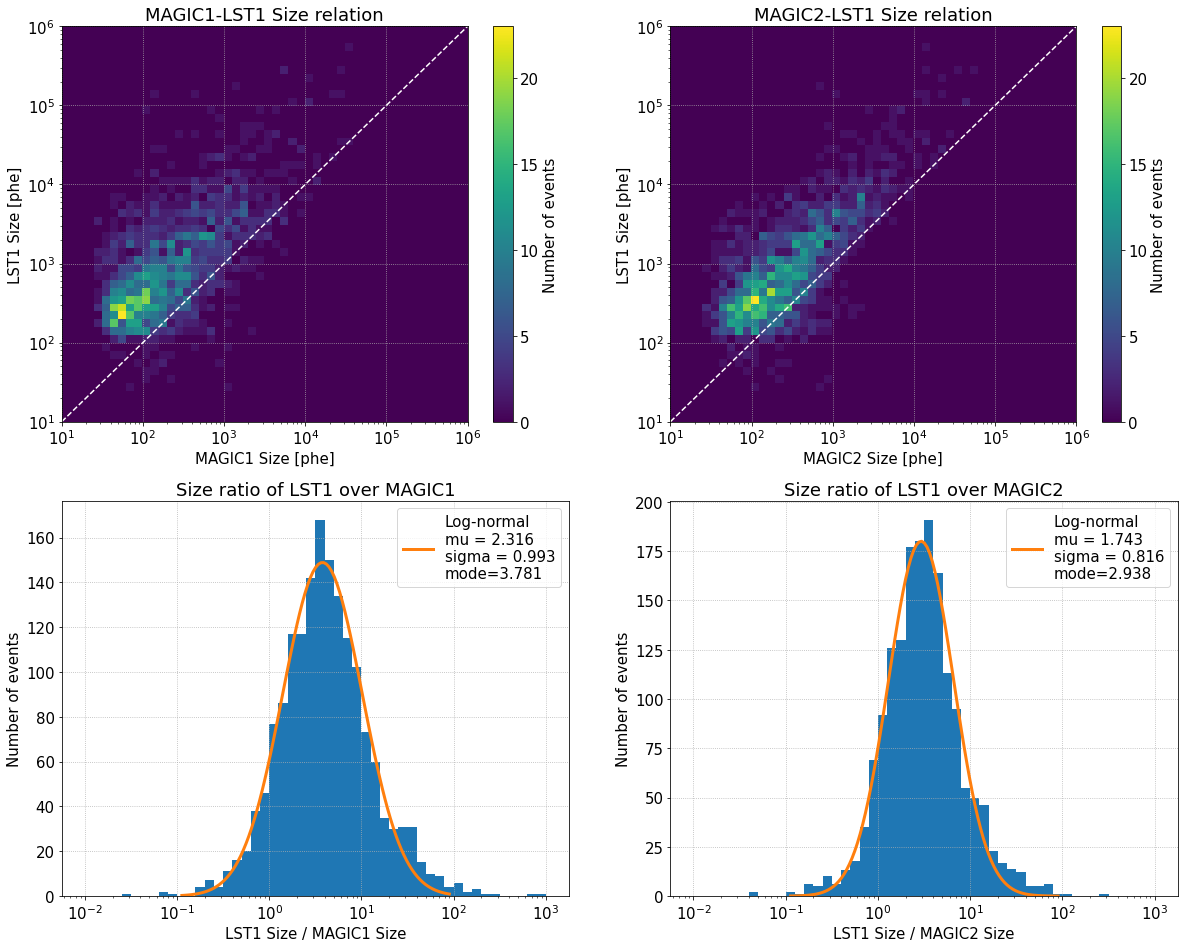

In [35]:
pyplot.figure(figsize=(20, 16))
grid = (2, 2)

for i_tel, tel_id in enumerate([5, 6]):
    df_lst = data_stereo.query('tel_id == 1')
    df_magic = data_stereo.query(f'tel_id == {tel_id}')
    
    # === 2d histogram ===
    pyplot.subplot2grid(grid, (0, i_tel))
    pyplot.title(f'MAGIC{i_tel+1}-LST1 Size relation')
    pyplot.xlabel(f'MAGIC{i_tel+1} Size [phe]')
    pyplot.ylabel('LST1 Size [phe]')
    pyplot.loglog()
    
    hist, xedges, yedges = np.histogram2d(df_magic['intensity'].values, df_lst['intensity'].values, bins=np.logspace(1, 6, 51))
    pyplot.pcolormesh(xedges, yedges, hist.transpose())

    bar = pyplot.colorbar()
    bar.set_label('Number of events')
    
    pyplot.plot((1e1, 1e6), (1e1, 1e6), color='white', linestyle='--')
    pyplot.grid(linestyle=':')
    
    # === Size ration distribution ===
    pyplot.subplot2grid(grid, (1, i_tel))
    pyplot.title(f'Size ratio of LST1 over MAGIC{i_tel+1}')
    pyplot.xlabel(f'LST1 Size / MAGIC{i_tel+1} Size')
    pyplot.ylabel('Number of events')
    pyplot.semilogx()
    
    hist = pyplot.hist(df_lst['intensity'].values/df_magic['intensity'].values, bins=np.logspace(-2, 3, 51))
    bins_center = (hist[1][1:] + hist[1][:-1])/2
    condition = (bins_center >= 0.1) & (bins_center < 100)
    popt, pcov = curve_fit(log_normal, bins_center[condition], hist[0][condition])
    
    mode = np.exp(popt[1] - popt[2]**2)
    bins_gaus = np.logspace(np.log10(bins_center[condition][0]), np.log10(bins_center[condition][-1]), 101)
    pyplot.plot(bins_gaus, log_normal(bins_gaus, popt[0], popt[1], popt[2]),
                       label='Log-normal\nmu = {:.3f}\nsigma = {:.3f}\nmode={:.3f}'.format(popt[1], popt[2], mode), linewidth=3)
    
    pyplot.grid()
    pyplot.legend()